<a href="https://colab.research.google.com/github/BJHeemskerk/DeepLearning_2024/blob/main/Opdracht%201/Portfolio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voorspellen van huisprijzen**

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Nima Ghafar|NimaGhafar|NimaGhafar|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Henry Lau|||
|Jesse van Leeuwen|22096337|22096337|

-- Opdrachtomschrijving --

## Inhoudsopgave
1. [H1: Importeren en inladen](#h1)
2. [H2: EDA](#h2)
3. [H3: Fully Connected Neural Network](#h3)

## H1: Importeren en inladen <a name='h1'></a>
Eerst zullen de verschillende gebruikte libaries worden geimporteerd.

In [13]:
# Importeren van veel gebruikte libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import datetime
import cv2

# Importeren libaries voor aanpassen/behandelen features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importeren DL libaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Normalization, Discretization, IntegerLookup, StringLookup, CategoryEncoding
from tensorflow.keras import layers


In [14]:
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1')


Nu zal de data worden ingeladen. Om hiermee te beginnen zullen de csv bestanden worden ingeladen.

In [17]:
# Inladen van csv bestanden
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Tonen van de data
display(train_data.head(), test_data.head())

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


In de volgende code cel wordt de data van elke afbeelding in de train en de test map opgehaald.

In [18]:
# Aanmaken van te vullen lijsten
file_paths_tr = []
imgdata_tr = []
file_paths_te = []
imgdata_te = []

# Opzetten directories
directories = ["Train", "Test"]

# Ophalen van de bestanden
# Loopen over directories
for directory in directories:
    directory_path = os.path.join('/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1', directory)
    # Loopen over alle bestanden
    for file in os.listdir(directory_path):
        # Alleen checken van .jpg bestanden
        if file.endswith(".jpg"):
            # Aanmaken van pad naar het bestand.
            file_path = os.path.join(directory_path, file)

            # Openen van de afbeelding en omzetten naar np.array
            img = Image.open(file_path)
            img_array = np.array(img)

            # Vullen van juiste lijsten op basis van ID
            if int(file.split('.')[0]) > 500:  # We halen de ID uit de bestandsnaam
                file_paths_te.append(file_path)
                imgdata_te.append(img_array)
            else:
                file_paths_tr.append(file_path)
                imgdata_tr.append(img_array)


Nu alle data in lijsten is gezet kunnen er dataframes worden aangemaakt met de data van de afbeeldingen. Door de grootte van de arrays kan dit even duren.

In [19]:
# Initieren van het dataframe
train_images = pd.DataFrame(columns=["House ID", "FilePath", "ImgData"])
test_images = pd.DataFrame(columns=["House ID", "FilePath", "ImgData"])

# Aanvullen train dataset
train_images["House ID"] = train_data["House ID"]
train_images["FilePath"] = file_paths_tr
train_images["ImgData"] = imgdata_tr

# Aanvullen test dataset
test_images["House ID"] = test_data["House ID"]
test_images["FilePath"] = file_paths_te
test_images["ImgData"] = imgdata_te

# Tonen van de dataframes
display(train_images.head(), test_images.head())

,House ID,FilePath,ImgData
0,1,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[166, 122, 73], [172, 128, 79], [168, 124, 7..."
1,2,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[234, 234, 234], [233, 233, 233], [231, 231,..."
2,3,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[156, 126, 100], [164, 137, 110], [181, 154,..."
3,4,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[187, 149, 64], [187, 149, 64], [186, 148, 6..."
4,5,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[185, 157, 94], [184, 156, 93], [183, 155, 9..."


,House ID,FilePath,ImgData
0,501,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[250, 250, 250], [251, 251, 251], [245, 245,..."
1,502,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[196, 186, 177], [194, 184, 175], [205, 195,..."
2,503,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[222, 205, 185], [229, 212, 192], [221, 204,..."
3,504,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[255, 253, 214], [255, 253, 214], [254, 252,..."
4,505,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[22, 20, 21], [36, 34, 35], [36, 34, 35], [3..."


Vervolgens zullen de dataframes worden getest door de afbeeldingen te tonen.

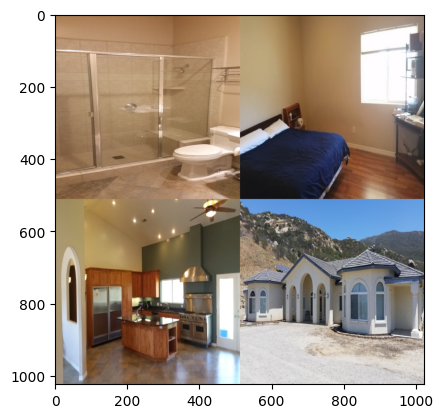

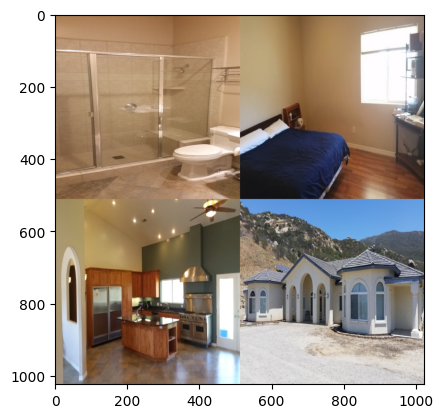

In [20]:
# Ophalen van pad naar afbeelding
image_path = train_images["FilePath"][0]

# Openen afbeelding
img = Image.open(image_path)

# Omzetten afbeelding naar np.array
img_array = np.array(img)

# Tonen van de afbeelding
plt.imshow(img)
plt.show()

# Opnieuw tonen van de afbeelding via DF
plt.imshow(train_images["ImgData"][0])
plt.show()

## H2: EDA <a name='h2'></a>

Met alle data ingeladen is het mogelijk om de data te gaan onderzoeken. Om hieraan te beginnen zal er gekeken worden naar de opmaak van de afbeeldingen.

In [21]:
# Maken van figuur voor afbeeldingen
plt.figure(figsize=(10, 10))
for i in range(9):
    # Maken van een subplot
    plt.subplot(3, 3, i + 1)

    # Inladen van de afbeelding
    plt.imshow(train_images["ImgData"][i])
    plt.axis('off')

# Tonen van afbeelding grootte
print(f"Afbeelding lengte en breedte: {train_images["ImgData"][0].shape}")

SyntaxError: f-string: unmatched '[' (<ipython-input-21-aa47533a640a>, line 12)

Voor de afbeeldingen is er sprake van een 3 dimensionale arrays waarin de data is opgeslagen. Met een grootte van (1024, 1024, 3) is er sprake van het volgende:
- Er zijn in totaal 1024 pixels (opgeslagen in kleine arrays) per afbeelding in zowel de lengte als de breedte.
- Elke array is drie getallen groot, deze getallen zijn de RGB getallen.

Met deze informatie is het mogelijk om later neurale netwerken op te stellen met de afbeeldingen als input. Voor andere neurale netwerken zal er gebruik worden gemaakt van de metadata die in het excel bestand beschikbaar is. Deze data zal nu worden bekeken en geanalyseerd.

In [22]:
# Bekijken van de kolom statistieken
print("Train dataframe kolom statistieken:")
display(train_data.describe(include='all'))

# Bekijken missende waarden en data-typen
print("Train dataframe kolom informatie:")
display(train_data.info())

Train dataframe kolom statistieken:


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


Train dataframe kolom informatie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


None

Van de vijf verschillende feature kolommen, dit zijn Bedrooms, Bathrooms, Area, Latitude en Longitude, is er geen sprake van aanwezige nul- of missende waarden. Ook in de target kolom zijn geen missende waarden te vinden. Echter zijn de waarden lastig te interpreteren voorsommige machine learning modellen, omdat de features erg verschillen qua grootte. Om dit op te lossen zal de data worden gescaled na het toepassen van train_test_split in de volgende paragraaf. Op deze manier zal de Price kolom niet worden aangepast.

Nu zal er gekeken worden naar de test dataset.

In [23]:
# Bekijken van de kolom statistieken
print("Test dataframe kolom statistieken:")
display(test_data.describe(include='all'))

# Bekijken missende waarden en data-typen
print("Test dataframe kolom informatie:")
display(test_data.info())

Test dataframe kolom statistieken:


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,518.000000,3.771429,2.600000,2297.171429,36.631043,-120.662114
std,10.246951,0.910259,0.591608,1457.127886,1.837672,1.670038
min,501.000000,2.000000,1.500000,987.000000,33.808500,-121.775800
25%,509.500000,3.000000,2.000000,1580.000000,34.724550,-121.775800
50%,518.000000,4.000000,2.500000,2012.000000,37.965800,-121.775800
75%,526.500000,4.000000,3.000000,2387.500000,37.965800,-119.311550
max,535.000000,7.000000,4.000000,9536.000000,37.965800,-117.922800


Test dataframe kolom informatie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


None

Alle opmerkingen over de train dataset gelden ook voor de test dataset. Er zijn geen nul- of missende waarden aanwezig en de enige toepassing die nodig lijkt is het scalen van de data.

Verder zal er aan de hand van verschillende visualisaties meer kennis worden opgedaan over de data.

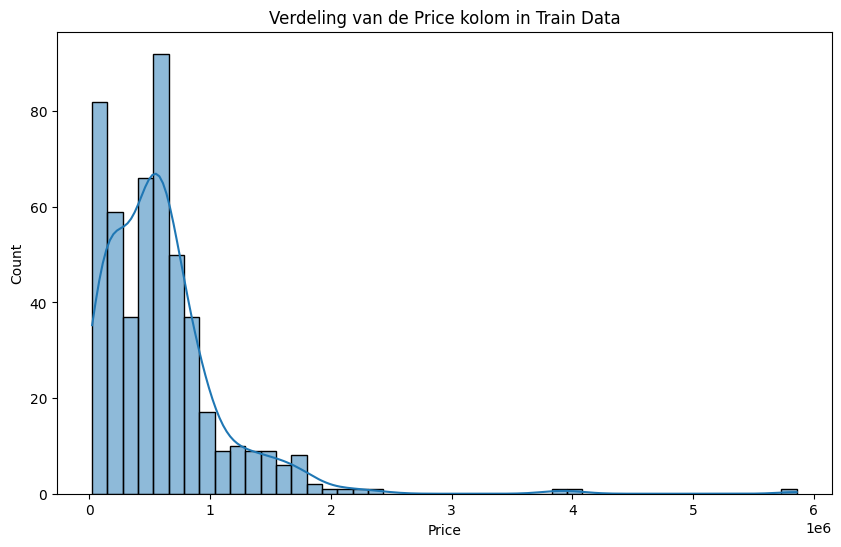

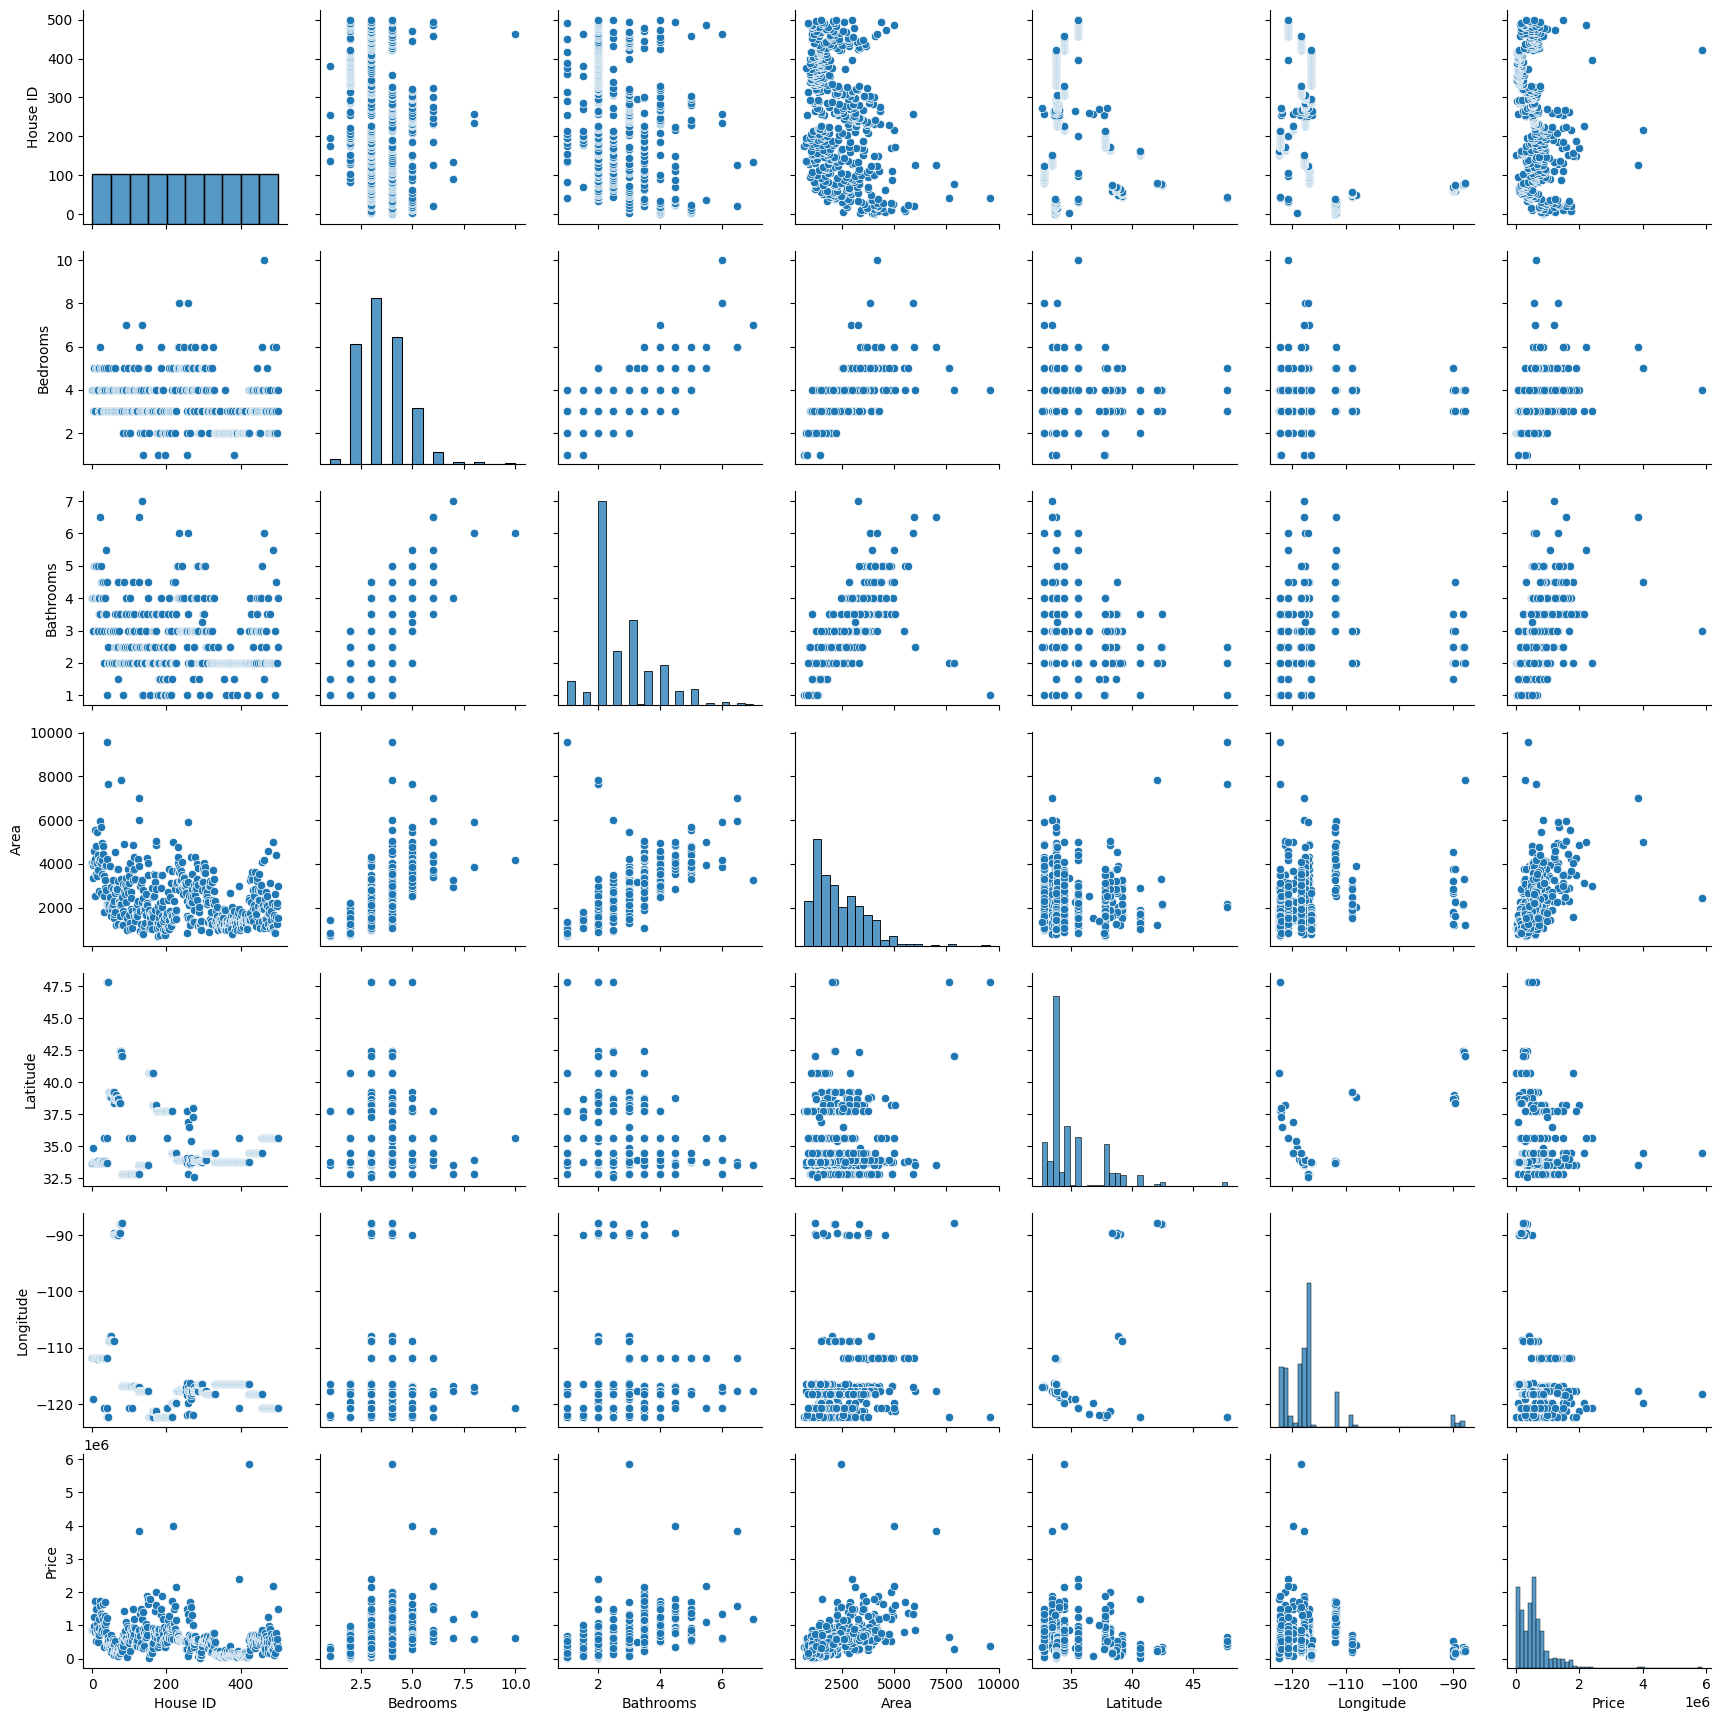

In [24]:
# Visualize the distribution of the target variable in the train dataframe
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Price'], kde=True)
plt.title('Verdeling van de Price kolom in Train Data')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

sns.pairplot(train_data)
plt.show()

Bij de verdeling van de prijs kolom is sprake van een sterke rechts-scheve verdeling. Dit ligt gedeeltelijk aan de paar aanwezige outliers in de data, maar ook aan de distributie van de waarden. In het blok dat meer bij elkaar ligt zit de piek namelijk niet in het midden, maar meer aan de rechter kant.

Bij de scatterplots van de price kolom met de andere feature is te zien dat het meerendeel van de features enige positieve correlatie heeft met de prijs. Om dit echter verder te onderzoeken zullen er heatmaps worden aangemaakt.

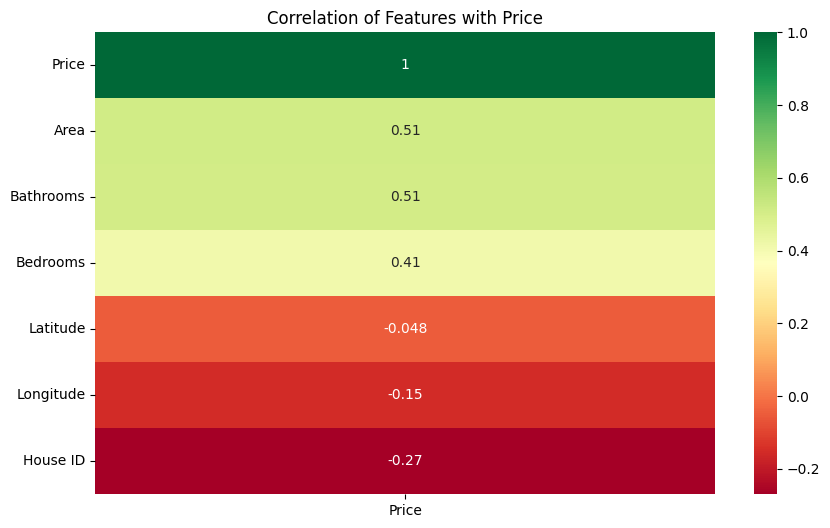

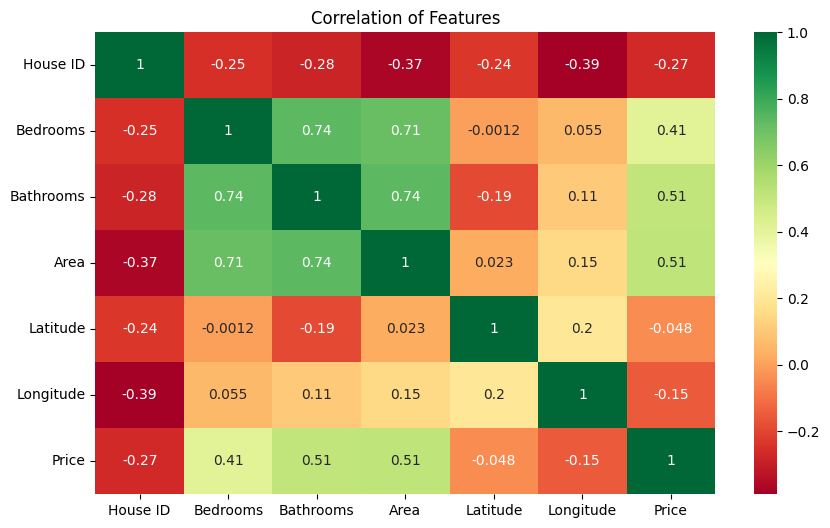

In [25]:
# Maak een heatmap met  cmap='RdYlGn' alleen op "Price" in de train dataframe en in volgorde van hoog naar laag
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.corr()[['Price']].sort_values(by='Price', ascending=False), annot=True, cmap='RdYlGn')
plt.title('Correlation of Features with Price')
plt.show()

# Maak een heatmap met  cmap='RdYlGn' voor alle kolommen in de train dataframe en in volgorde van hoog naar laag

plt.figure(figsize=(10, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='RdYlGn')
plt.title('Correlation of Features')
plt.show()


Bij de features latitude (corr = -0.048) en longitude (corr = -0.15) is de correlatie het kleinste en deze waarden zijn als enige negatief. De correlaties bij Bedrooms (corr = 0.41) en Bathrooms (corr = 0.51) zijn al sterker, maar ook niet extreem overtuigend. De correlatie met de area kolom is gelijk aan die van Bathrooms, met een waarde van 0.51. Correlaties van 0.5 worden beschouwd als een gematigde positieve correlatie.

Tussen de features zelf is er nauwelijks sprake van sterke correlaties. De enige twee kolommen die sterker correleren zijn Bedrooms en Bathrooms. Echter waarborgd een correlatie van 0.7 nog geen zorgen op en hoeft er volgens ons niks te worden aangepast aan deze kolommen.

## H3: Splitsen en scalen

Voordat er neurale netwerken kunnen worden opgesteld, zal eerst nog de train_data dataset worden opgesplitst in een test en een validatie set.

In [26]:
# Aanmaken van de random_state SEED
SEED = 42

# Opslitsten van data in X en y
X = train_data.drop(['House ID', 'Price'], axis=1)
y = train_data['Price']

# Toepassen van train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.1, random_state=SEED
                                       )

 Daarna nog een keer splitten om een validatie set te krijgen

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

Nu volgt het scalen van de feature data, dit zorgt ervoor dat het model betere verbanden kan leggen tussen de verschillende variabelen.

In [28]:
# Scalen van de gesplitste data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Scalen van de test_data
# Aanmaken lijst met nodige kolomnamen
kolomnamen = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude"]

# Scalen van de nodige kolommen
test_fe = test_data[kolomnamen]
sc_test_fe = scaler.transform(test_fe)
test_features_dict = {
    'Bedrooms': sc_test_fe[:, 0],
    'Bathrooms': sc_test_fe[:, 1],
    'Area': sc_test_fe[:, 2],
    'Latitude': sc_test_fe[:, 3],
    'Longitude': sc_test_fe[:, 4]
}

## Voorbereiding voor Model met Preprocessing Layers

In deze sectie bereiden we onze dataset voor met preprocessing layers. Dit omvat het normaliseren van onze numerieke features en eventueel het verwerken van categorische features. Door deze preprocessing als onderdeel van ons model te definiëren, zorgen we ervoor dat onze data automatisch wordt voorbereid tijdens training en inferentie, wat het proces vereenvoudigt en fouten voorkomt.


In [29]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization(axis=None)
    # Use the dataset to calculate the mean and variance for the feature
    feature_values = np.array(dataset[name])
    feature_values = feature_values.reshape(-1, 1)
    normalizer.adapt(feature_values)
    return normalizer



In [30]:
# Aanpassing voor het Model met Preprocessed Inputs
all_inputs = []
all_features = []

# Numerieke features preprocessen
for header in ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, X_train)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    all_features.append(encoded_numeric_col)

preprocessed_features = layers.concatenate(all_features)


In [31]:
## Conversie van Pandas DataFrames naar tf.data.Dataset

def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = labels.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Aanmaken van tf.data.Dataset objecten voor training, validatie en testen
train_ds = df_to_dataset(X_train, y_train, batch_size=32)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=32)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=32)


## H3: Fully Connencted Neural Network <a name='h3'></a>

Nu kan er worden begonnen met het opzetten van verschillende voorspellingen. Het eerste type voorspelling dat voor zal komen is een Fully Connected Neural Network. Dit netwerk bestaat uit de volgende lagen:

**Input laag:**<br>
De input laag van een neuraal netwerk bestaat uit een bepaald aantal neuronen. Het aantal neuronen moet gelijk zijn aan het aantal features dat in de dataset beschikbaar is. In onze datasets zijn er 5 features te vinden, dus heeft de input laag 5 neuronen.

In alle hidden layers is gebruik gemaakt van een trial & error aanpak, waarmee er met verschillende hoeveelheden van neuronen en verschillende activatie functies is getest. Uiteindelijk kwamen hier de volgende aantallen en activaties uit:

**Hidden Layer 1:**<br>
- Neuronen: 128
- Activatie: Rectified Linear Unit

**Hidden Layer 2:**<br>
- Neuronen: 64
- Activatie: Rectified Linear Unit

**Hidden Layer 3:**<br>
- Neuronen: 64
- Activatie: Rectified Linear Unit

**Hidden Layer 4:**<br>
- Neuronen: 16
- Activatie: Rectified Linear Unit

Voor de output laag geldt ongeveer hetzelfde als voor de input laag. Het aantal neuronen in de output laag hoort gelijk te zijn aan het aantal klassen die worden voorspeld bij classificatie. Bij regressie taken is er vaak maar 1 neuron in de output laag aanwezig, omdat er een eenvoudige numerieke voorspelling wordt gemaakt. In ons regressie probleem is deze waarde de huisprijs. Bij regressie is er ook sprake van de activatie functie 'linear', ookwel bekend als geen activatie.

In [32]:
# Aanmaken NN mbv Sequential API
fcnn = Sequential()

# Toevoegen input en eerste hidden layer
fcnn.add(Dense(128, input_shape=(5,), activation='relu'))

# Toevoegen andere hidden layers
fcnn.add(Dense(64, activation='relu'))
fcnn.add(Dense(64, activation='relu'))
fcnn.add(Dense(16, activation='relu'))

# Toevoegen van output layer
fcnn.add(Dense(1, activation='linear'))

Nadat alle lagen van het model zijn opgesteld, is het tijd om het model te compilen. Deze stap voegt enkele parameters toe aan het model:
- De optimizer, een algoritme dat bepaalt op welke wijze het model leert tijdens het trainen.
- De loss functie, een functie die aantoont hoe goed het model presteert op de gegevens.
- De metric, een extra, optionele meetwaarde voor de prestatie van het model.

Voor ons model is er gekozen voor de volgende parameters:
- De Adam (Adaptive Moment estimator) optimizer
- Mean Squared Error als loss
- Mean Absolute Percentage Error als metric.

Als metric is er gekozen voor de MAPE, omdat deze metric ook wordt gebruikt in de kaggle competitie. De mean squared error is een vetrouwbare loss functie die veel wordt gebruikt in Machine Learning en geeft een goede indicatie over de precisie van de voorspelling. De Adam optimizer is een van de meest populaire optimizers voor Neurale Netwerken en is hierom ook gekozen bij dit model. De adam (Adaptive Moment Estimation) optimizer gebruikt twee moving averages per parameter, waarmee de optimizer de learning rate voor de voorspelling dynamisch aanpast tijdens het trainings proces.

Daarnaast is er ook een module aangemaakt om het model eerder te kunnen stoppen, in het geval dat er niet veel meer veranderd aan de loss van de validatie data.

In [ ]:
# Compilen van het model
fcnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
)

# Maken van een vroege stop module
early_stop = EarlyStopping(
    monitor='val_loss', patience=25, restore_best_weights=True
    )

Nu alles is aangemaakt kan het model worden getrained. Hierbij gebruiken we de trainings data, de validatie data, een gekozen aantal epochs, een batch size en een callback module. De epochs staan voor het aantal iteraties dat het model door zal gaan, door gebruik van de callback module is er gekozen om 5000 epochs uit te voeren. Zodra de loss op de validatie set voor 100 epochs niet genoeg veranderd zal het model automatisch stoppen en worden de parameters van de beste epoch hersteld. De batch size wijst op het aantal datapunten dat per epoch wordt gebruikt, bij ons is er gekozen voor een batch size van 16.

In [ ]:
# Fitten van het model met de data
h_fcnn = fcnn.fit(
    X_train, y_train,
    batch_size=16,
    epochs=5000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/5000
29/29 [==============================] - 1s 13ms/step - loss: 645015076864.0000 - mean_absolute_percentage_error: 99.5295 - val_loss: 482240266240.0000 - val_mean_absolute_percentage_error: 96.2283
Epoch 2/5000
29/29 [==============================] - 0s 4ms/step - loss: 478819581952.0000 - mean_absolute_percentage_error: 79.4057 - val_loss: 160294699008.0000 - val_mean_absolute_percentage_error: 99.2304
Epoch 3/5000
29/29 [==============================] - 0s 4ms/step - loss: 236200558592.0000 - mean_absolute_percentage_error: 89.0504 - val_loss: 134089678848.0000 - val_mean_absolute_percentage_error: 73.0425
Epoch 4/5000
29/29 [==============================] - 0s 3ms/step - loss: 201902112768.0000 - mean_absolute_percentage_error: 71.2075 - val_loss: 125065969664.0000 - val_mean_absolute_percentage_error: 79.8010
Epoch 5/5000
29/29 [==============================] - 0s 3ms/step - loss: 186252312576.0000 - mean_absolute_percentage_error: 76.1713 - val_loss: 107107311616.

Met het getrainde model kan er gekeken worden naar de loss van de train data en de validatie data. Op deze manier kan er in een enkele grafiek worden gezien of er sprake is van overfitting of andere problemen.

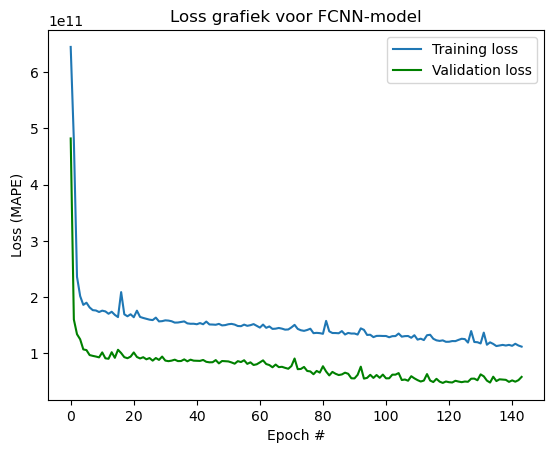

In [ ]:
plt.plot(h_fcnn.history['loss'], label='Training loss')
plt.plot(h_fcnn.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss grafiek voor FCNN-model')
plt.legend()
plt.show()

Zoals in de grafiek is te zien, is er sprake van geen van overfitting. Overfitting wordt namelijk aangeduid door het stijgen van de validatie loss.

Nu het model is getrained en de loss is bekeken, kan de voorspelling worden geupload naar kaggle. Aan de hand van de voorspellingen kan er een csv bestand aangemaakt worden voor de kaggle competitie. Omdat deze bestanden vaker moeten worden aangemaakt en om de bestanden overzichtelijk en uniform te houden is hiervoor een functie aangemaakt.

In [39]:
def kaggle_csv(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : ML-model of DL-model
        De naam die is gegeven aan het ML-model of DL-model
        dat wordt gebruikt om te voorspellen

    suffix : str
        De 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Aanmaken van de voorspelling
    y_pred = model.predict(sc_test_fe)

    # Aanmaken df met alleen House ID en Price
    test_predictions_df = pd.DataFrame(
        {'House ID': test_data['House ID'],
        'Price': np.ravel(y_pred)})

    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle/voorspelling_{suffix}_{tijd}.csv',
        index=False)

    # Print voor conformatie
    print(f'voorspelling_{suffix}_{tijd}.csv has been saved!')

Nu zal de functie worden uitgevoerd om de voorspellingen te verkrijgen.

In [40]:
# Uitvoeren van kaggle_csv functie
kaggle_csv(fcnn, 'FCNN-1')

2/2 [==============================] - 0s 6ms/step
voorspelling_FCNN-1_0320145750.csv has been saved!


In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1/modelversies/fcnn_model_v1.h5'
fcnn.save(model_save_path)


In [ ]:
from tensorflow.keras.models import load_model


model_load_path = '/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1/modelversies/fcnn_model_v1.h5'


model = load_model(model_load_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14241 (55.63 KB)
Trainable params: 14241 (55.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Modelaanpassingen en Verbeteringen

In deze versie van het neurale netwerkmodel zijn verschillende aanpassingen gemaakt ten opzichte van de eerste versie van het model. Deze wijzigingen zijn bedoeld om de modelprestaties te verbeteren, zoals gemeten door een lagere Mean Absolute Percentage Error (MAPE) op Kaggle. Hier volgt een overzicht van de belangrijkste aanpassingen:

### Architectuur van het Model
- **Verhoging van het Aantal Neuronen**: In elke laag van het model is het aantal neuronen aangepast om de modelcomplexiteit te verhogen. Dit stelt het model in staat om complexere patronen in de data te leren.
    - De inputlaag en de eerste verborgen laag bevatten nu 128 neuronen.
    - De tweede verborgen laag bevat 64 neuronen.
    - De derde verborgen laag bevat 32 neuronen.
- **Dropout Toegevoegd**: In elke verborgen laag is een dropout van 0.2 toegepast. Dropout helpt overfitting te verminderen door willekeurig een deel van de neuronen tijdens de training uit te schakelen, wat zorgt voor een robuuster netwerk.

### Hyperparameters
- **Learning Rate**: De learning rate van de Adam optimizer is ingesteld op 0.001. Dit is een standaardwaarde die vaak een goed evenwicht biedt tussen snelheid en nauwkeurigheid van de training.
- **Batch Size**: De batch size is vastgesteld op 32. Dit is een veelgebruikte grootte die een goede balans biedt tussen de snelheid van de training en de nauwkeurigheid van de gradient updates.
- **Aantal Epochs**: Er is gekozen voor een maximum van 1000 epochs, met early stopping toegepast om te voorkomen dat het model te lang traint en overfit raakt.

### Training en Validatie
- **Validation Split**: Een validatiesplit van 0.2 wordt gebruikt om een deel van de trainingsdata apart te zetten voor validatiedoeleinden. Dit helpt bij het monitoren van het modelprestaties op niet-getrainde data.
- **Early Stopping**: Early stopping wordt gebruikt met een `patience` van 20 epochs. Dit betekent dat de training stopt als het validatieverlies voor 20 opeenvolgende epochs niet verbetert, waarbij de beste modelgewichten worden hersteld.

Deze aanpassingen zijn gemaakt met het doel om de nauwkeurigheid van het model te verbeteren en overfitting te verminderen. Door het aantal neuronen te verhogen en dropout toe te passen, is het model beter in staat om de onderliggende patronen in de data te leren zonder te veel te leren van de ruis of specifieke details van de trainingsset.




**versie 2 van het model**


eerst zullen we feature engineering doen

In [33]:
train_data['BedBath'] = train_data['Bedrooms'] * train_data['Bathrooms']
test_data['BedBath'] = test_data['Bedrooms'] * test_data['Bathrooms']

train_data['AreaLat'] = train_data['Area'] * train_data['Latitude']
test_data['AreaLat'] = test_data['Area'] * test_data['Latitude']


train_data['Area_Cat'] = pd.cut(train_data['Area'], bins=[train_data['Area'].min(), train_data['Area'].quantile(0.33), train_data['Area'].quantile(0.66), train_data['Area'].max()], labels=['Small', 'Medium', 'Large'])
test_data['Area_Cat'] = pd.cut(test_data['Area'], bins=[test_data['Area'].min(), test_data['Area'].quantile(0.33), test_data['Area'].quantile(0.66), test_data['Area'].max()], labels=['Small', 'Medium', 'Large'])

=
train_data = pd.get_dummies(train_data, columns=['Area_Cat'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Area_Cat'], drop_first=True)

In dit deel van de code hebben we een paar slimme aanpassingen gemaakt om onze data nog beter te maken voor het model. Dit noemen we feature engineering, en het helpt het model om beter te begrijpen wat belangrijk is en wat niet.

1. **'BedBath' Feature**:
   We hebben een nieuw kenmerk gemaakt door het aantal slaapkamers en badkamers bij elkaar op te tellen. Dit hebben we 'BedBath' genoemd. We dachten dat dit handig zou zijn omdat huizen vaak worden gewaardeerd op hoeveel slaapkamers en badkamers ze hebben. Dit deden we zowel voor de trainingsdata als voor de testdata.

2. **'AreaLat' Feature**:
   Hier hebben we de oppervlakte van een huis vermenigvuldigd met de breedtegraad om een nieuw kenmerk te maken, 'AreaLat'. Het idee is dat waar een huis staat (de breedtegraad) en hoe groot het is allebei belangrijk kunnen zijn voor de prijs. Dit hebben we ook voor beide datasets gedaan.

3. **'Area' in Categorieën**:
   We hebben de oppervlakte van huizen in drie groepen verdeeld: klein, middelgroot en groot. Dit hebben we gedaan op basis van hoe groot de oppervlaktes zijn vergeleken met elkaar. Door dit te doen, kan het model misschien makkelijker verbanden zien tussen de grootte van een huis en de prijs.

4. **Categorieën Omzetten naar Getallen**:
   De groepen die we voor de oppervlakte hebben gemaakt, hebben we omgezet in een soort code met getallen, wat nodig is zodat het model er iets mee kan. We zorgen er ook voor dat we niet te veel van dezelfde soort codes krijgen, wat problemen kan veroorzaken.

Deze stappen helpen om onze data net dat beetje extra te geven, waardoor het model beter kan leren en uiteindelijk betere voorspellingen kan doen hopelijk


In [48]:



X = train_data.drop(['Price'], axis=1)
y = train_data['Price']


X_train_fe, X_test_fe, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Pas de test_size aan indien nodig


scaler = StandardScaler()
X_train_fe_scaled = scaler.fit_transform(X_train_fe)
X_test_fe_scaled = scaler.transform(X_test_fe)



Nadat we onze data een beetje hebben opgepoetst met nieuwe kenmerken, is het tijd om het voor te bereiden voor ons model. Dit deel van de code zorgt daarvoor:

1. **Splitsen in Features en Target**:
   Eerst verdelen we onze data in twee delen: `X` en `y`. In `X` stoppen we alle kenmerken die we denken dat iets zeggen over de prijs van een huis (alles behalve de prijs zelf). `y` is juist waar de prijzen in staan die we willen voorspellen.

2. **Verdelen in Train- en Testset**:
   Met `train_test_split` verdelen we onze data weer verder in twee groepen: een om het model mee te trainen, en een om te testen of het goed geleerd heeft. We houden 20% van de data apart als testset, en de rest gebruiken we om te leren.

3. **Normaliseren van de Data**:
   Dan gebruiken we `StandardScaler` om onze kenmerken te normaliseren. Dit betekent dat we ervoor zorgen dat grote getallen of hele kleine getallen geen problemen opleveren voor ons model. Het model kan hierdoor makkelijker leren en sneller goede voorspellingen doen.

Dit is eigenlijk een soort voorbereidingsritueel voor onze data. Als we dit goed doen, geeft dat ons model de beste kans om iets nuttigs te leren.


Epoch 1/5000
25/25 [==============================] - 2s 12ms/step - loss: 670052188160.0000 - mean_absolute_percentage_error: 99.7427 - val_loss: 467298091008.0000 - val_mean_absolute_percentage_error: 98.2480
Epoch 2/5000
25/25 [==============================] - 0s 4ms/step - loss: 577429635072.0000 - mean_absolute_percentage_error: 85.7932 - val_loss: 228294967296.0000 - val_mean_absolute_percentage_error: 65.3531
Epoch 3/5000
25/25 [==============================] - 0s 4ms/step - loss: 274842058752.0000 - mean_absolute_percentage_error: 104.4564 - val_loss: 113762893824.0000 - val_mean_absolute_percentage_error: 88.7701
Epoch 4/5000
25/25 [==============================] - 0s 3ms/step - loss: 237183696896.0000 - mean_absolute_percentage_error: 80.2114 - val_loss: 92466159616.0000 - val_mean_absolute_percentage_error: 68.8942
Epoch 5/5000
25/25 [==============================] - 0s 4ms/step - loss: 214991011840.0000 - mean_absolute_percentage_error: 62.0676 - val_loss: 84019314688.0

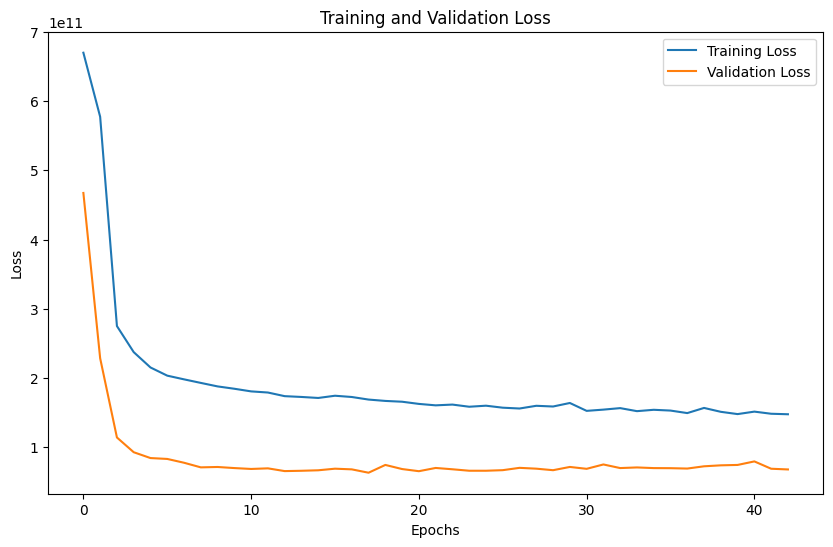

In [45]:
input_shape = (X_train_fe.shape[1],)


fcnn2 = Sequential([
    Dense(128, input_shape=input_shape, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])


fcnn2.compile(optimizer=Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_absolute_percentage_error'])


early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


h_fcnn2 = fcnn2.fit(X_train_fe_scaled, y_train,
                    batch_size=16,
                    epochs=5000,
                    validation_data=(X_test_fe_scaled, y_test),
                    callbacks=[early_stop])



plt.figure(figsize=(10, 6))
plt.plot(h_fcnn2.history['loss'], label='Training Loss')
plt.plot(h_fcnn2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
def kaggle_csv(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : ML-model of DL-model
        De naam die is gegeven aan het ML-model of DL-model
        dat wordt gebruikt om te voorspellen

    suffix : str
        De 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Aanmaken van de voorspelling
    y_pred = model.predict(sc_test_fe)

    # Aanmaken df met alleen House ID en Price
    test_predictions_df = pd.DataFrame(
        {'House ID': test_data['House ID'],
        'Price': np.ravel(y_pred)})

    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle/voorspelling_{suffix}_{tijd}.csv',
        index=False)

    # Print voor conformatie
    print(f'voorspelling_{suffix}_{tijd}.csv has been saved!')

In [47]:
# Uitvoeren van kaggle_csv functie
kaggle_csv(fcnn2, 'FCNN-2')


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 5)


## CNN from Scratch


- [ ] Bouw een convolutioneel neuraal netwerkmodel om de prijzen te voorspellen op basis van de afbeeldingen.


- [ ] Plot je modelarchitectuur met behulp van een geschikte visualisatietool.
- [ ] Onderbouw je keuzes van het aantal lagen, het aantal neuronen per laag, de activeringsfuncties, de keuze van optimizer en het aantal trainingsepochs.


- [ ] Gebruik een of meer van de volgende technieken in je model. Beschrijf en motiveer je keuze:
    - [ ] L1 regularisatie
    - [ ] L2 regularisatie
    - [ ] Dropout
    - [ ] Batchnorm

- [ ] Beschrijf welke vormen van data augmentation (indien van toepassing) geschikt zijn voor dit probleem. Implementeer dit in je datapijplijn.
- [ ] Compile je model met je gekozen lossfunctie en optimizer, en train deze op de afbeeldingen.

# Transfer Learning

# Multimodaal model